In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np

# Load the VGG16 model without the top (classification) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Get the last but one layer of the base model
last_but_one_layer = base_model.get_layer('block5_conv3').output

# Apply GlobalAveragePooling2D to the last but one layer
gap_layer = tf.keras.layers.GlobalAveragePooling2D()(last_but_one_layer)

# Create the final model
model = Model(inputs=base_model.input, outputs=gap_layer)

# Data generator
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_directory(
    "D:\SEM-4\PROJECTS\ML\Archive",  
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,  
    shuffle=False)

# Predict features using the final model
features = model.predict(generator, steps=np.ceil(generator.samples/generator.batch_size))

# Get the labels
labels = generator.classes

# Save the extracted features and labels
np.save('extracted_features.npy', features)
np.save('labels.npy', labels)

# Load the saved features and labels
loaded_features = np.load('extracted_features.npy')
loaded_labels = np.load('labels.npy')




Found 42500 images belonging to 13 classes.
   2/1329 [..............................] - ETA: 2:43:00

C:\Users\garik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  26/1329 [..............................] - ETA: 49:19

C:\Users\garik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (96714256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1148/1329 [========================>.....] - ETA: 5:31

C:\Users\garik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\TiffImagePlugin.py:868: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


1329/1329 [==============================] - 2304s 2s/step


In [2]:
import numpy as np

loaded_features = np.load('extracted_features.npy')

print("Shape of loaded features:", loaded_features.shape)

Shape of loaded features: (42500, 512)


In [3]:
import numpy as np
from sklearn.decomposition import PCA

loaded_features = np.load('extracted_features.npy')
loaded_labels = np.load('labels.npy')

pca = PCA(n_components=5)
reduced_features = pca.fit_transform(loaded_features)

class_indices_to_names = {
    0: 'Academic Art',
    1: 'Art Nouveau',
    2: 'Baroque',
    3: 'Expressionism',
    4: 'Japanese Art',
    5: 'Neoclassism',
    6: 'Primitivism',
    7: 'Realism',
    8: 'Renaissance',
    9: 'Rococo',
    10: 'Romanticism',
    11: 'Symbolism',
    12: 'Western Medieval'
}

reduced_features_by_class = {name: [] for name in class_indices_to_names.values()}

for feature, label in zip(reduced_features, loaded_labels):
    class_name = class_indices_to_names[label]
    reduced_features_by_class[class_name].append(feature)

for class_name, features in reduced_features_by_class.items():
    print(f"Class: {class_name}, Number of Feature Vectors: {len(features)}")
    for feature_vector in features:
        print(feature_vector)
    print("\n")  

Class: Academic Art, Number of Feature Vectors: 1305
[ 0.41004854  0.5399811  -0.07302776 -0.03123298  0.62959623]
[ 0.00957381  0.6854535  -0.14947705 -0.310985    0.10142839]
[-1.3656276   0.75390977  1.4688057   0.78298837 -0.15215947]
[-1.3539146   0.52673477  1.7403361   0.4602622  -0.35024923]
[ 0.6545461   1.3040857  -0.15503977 -0.20572454  0.00554298]
[ 1.0516465   1.9363005  -0.24192262  0.27149406  0.19288574]
[-0.80814     1.6129979   0.3012494   0.28288412 -0.12816833]
[-0.16809097  1.444536   -0.02335909  0.30472973 -0.06063403]
[ 0.4942049   1.3408735  -0.13477561  0.04977854  0.22425221]
[ 0.39211828  0.22310455  0.5898942  -0.38457203 -0.22102119]
[-0.47122717  0.40804023  0.77987283 -0.2326415   0.7095831 ]
[ 0.21297191  1.0858154   0.46202368  0.18238477 -0.02285325]
[ 0.19235936  2.1091323  -0.4210038   0.06185389  0.6055086 ]
[ 0.68378377  0.7638001  -0.8834267   0.11630315  0.90571094]
[ 0.49928874  1.116142   -0.14674127 -0.63145894  0.90589535]
[ 0.4322663   1.5

In [4]:
import numpy as np
from numpy.linalg import norm

class_centroids = {}
class_spreads = {}

for class_name, features in reduced_features_by_class.items():
    features_np = np.array(features)
    class_centroids[class_name] = np.mean(features_np, axis=0)
    class_spreads[class_name] = np.std(features_np, axis=0)

for class_name in class_centroids:
    print(f"Class: {class_name}")
    print(f"  Centroid (Mean): {class_centroids[class_name]}")
    print(f"  Spread (Standard Deviation): {class_spreads[class_name]}\n")

distance = norm(class_centroids['Academic Art'] - class_centroids['Art Nouveau'])
print(f"Distance between centroids of 'Academic Art' and 'Art Nouveau': {distance}")

Class: Academic Art
  Centroid (Mean): [ 0.08595626  0.6076268   0.04836547 -0.0861994   0.02264403]
  Spread (Standard Deviation): [0.6671287  0.7551444  0.5443462  0.47962308 0.43218574]

Class: Art Nouveau
  Centroid (Mean): [-0.8298326  -0.2655678  -0.08349805  0.02704132  0.17475471]
  Spread (Standard Deviation): [0.84896076 0.6575533  0.52458507 0.52502614 0.54424727]

Class: Baroque
  Centroid (Mean): [ 0.37682042  0.15517819  0.16383259 -0.12708606 -0.01523993]
  Spread (Standard Deviation): [0.7694369  0.8428397  0.60811925 0.45151028 0.44792128]

Class: Expressionism
  Centroid (Mean): [-0.27416962  0.3636209  -0.14505465  0.12329729 -0.03634965]
  Spread (Standard Deviation): [0.87439877 0.73640025 0.5296204  0.54381555 0.5361125 ]

Class: Japanese Art
  Centroid (Mean): [-0.66829383  0.03379038 -0.13598205  0.10745147  0.25080395]
  Spread (Standard Deviation): [0.77372307 0.68392545 0.4704609  0.48023552 0.49228692]

Class: Neoclassism
  Centroid (Mean): [-0.48735097 -0.3

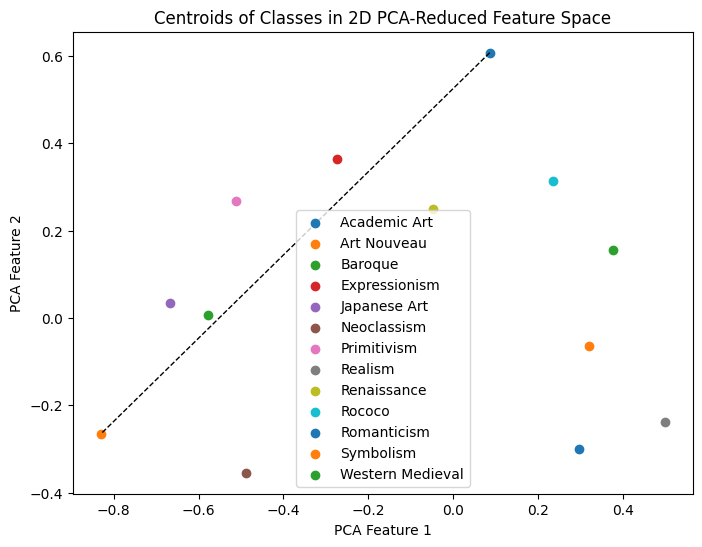

In [5]:
import matplotlib.pyplot as plt

pca_2d = PCA(n_components=2)
reduced_features_2d = pca_2d.fit_transform(reduced_features)

centroids_2d = {}
for class_name, features in reduced_features_by_class.items():
    features_2d = pca_2d.transform(np.array(features))  # Transform to 2D
    centroids_2d[class_name] = np.mean(features_2d, axis=0)

plt.figure(figsize=(8, 6))
for class_name, centroid in centroids_2d.items():
    plt.scatter(centroid[0], centroid[1], label=class_name)

plt.plot([centroids_2d['Academic Art'][0], centroids_2d['Art Nouveau'][0]],
         [centroids_2d['Academic Art'][1], centroids_2d['Art Nouveau'][1]],
         'k--', linewidth=1)

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Centroids of Classes in 2D PCA-Reduced Feature Space')
plt.legend()
plt.show()

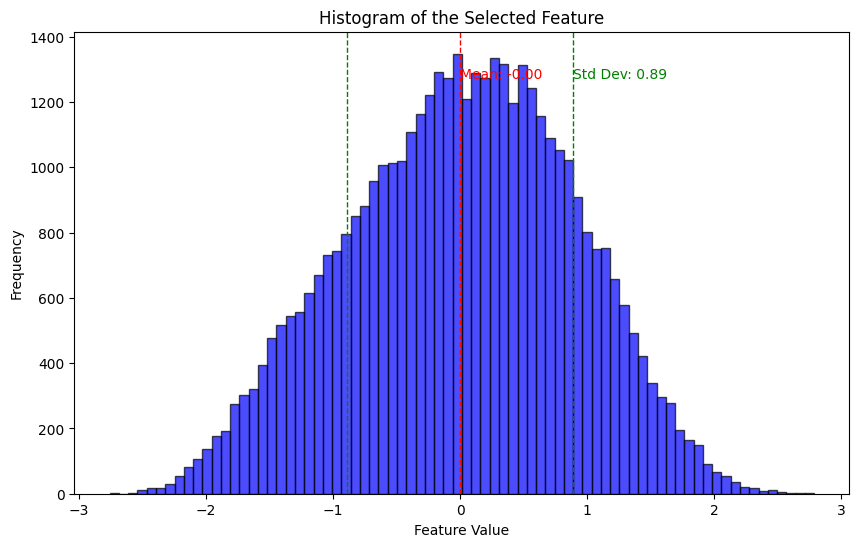

Mean of the selected feature: -3.0215992410376202e-06
Variance of the selected feature: 0.7901504635810852


In [6]:
import matplotlib.pyplot as plt
import numpy as np

selected_feature = reduced_features[:, 0]

hist_data, bin_edges = np.histogram(selected_feature, bins='auto')

mean = np.mean(selected_feature)
variance = np.var(selected_feature)

plt.figure(figsize=(10, 6))
plt.hist(selected_feature, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of the Selected Feature')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.text(mean, plt.ylim()[1]*0.9, f'Mean: {mean:.2f}', color = 'red')
plt.axvline(mean - np.sqrt(variance), color='g', linestyle='dashed', linewidth=1)
plt.axvline(mean + np.sqrt(variance), color='g', linestyle='dashed', linewidth=1)
plt.text(mean + np.sqrt(variance), plt.ylim()[1]*0.9, f'Std Dev: {np.sqrt(variance):.2f}', color = 'green')

plt.show()

print(f"Mean of the selected feature: {mean}")
print(f"Variance of the selected feature: {variance}")

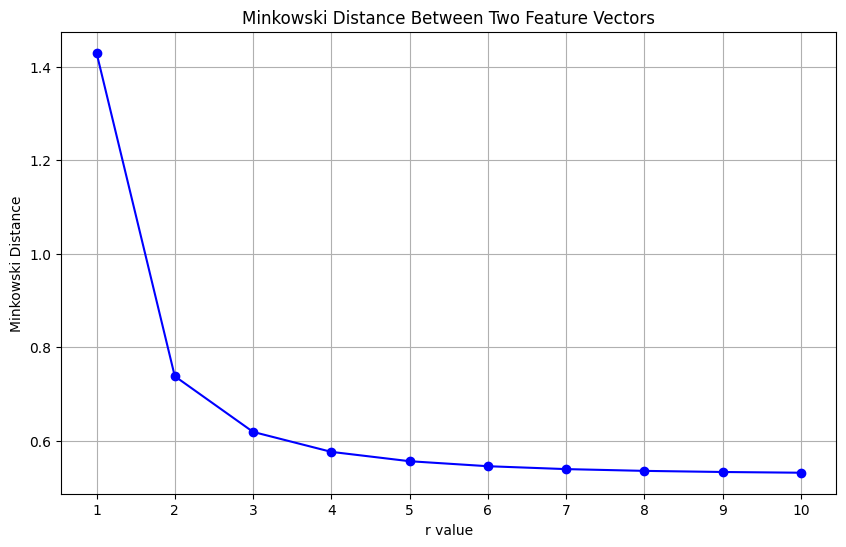

In [7]:
import numpy as np
from scipy.spatial.distance import minkowski
import matplotlib.pyplot as plt

feature_vector_1 = reduced_features[0]
feature_vector_2 = reduced_features[1]

r_values = range(1, 11)
distances = [minkowski(feature_vector_1, feature_vector_2, r) for r in r_values]

plt.figure(figsize=(10, 6))
plt.plot(r_values, distances, marker='o', linestyle='-', color='b')
plt.title('Minkowski Distance Between Two Feature Vectors')
plt.xlabel('r value')
plt.ylabel('Minkowski Distance')
plt.xticks(r_values)
plt.grid(True)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

selected_class_indices = [0, 1]  

selected_features = loaded_features[np.isin(loaded_labels, selected_class_indices)]
selected_labels = loaded_labels[np.isin(loaded_labels, selected_class_indices)]

selected_labels = np.array([0 if label == selected_class_indices[0] else 1 for label in selected_labels])

X_train, X_test, y_train, y_test = train_test_split(selected_features, selected_labels, test_size=0.3, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape) 

Training set size: (3038, 512)
Testing set size: (1302, 512)


In [9]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

neigh.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [10]:
accuracy = neigh.score(X_test, y_test)
print(accuracy)

0.8709677419354839


In [11]:
test_vect = X_test[0] 
predicted_class = neigh.predict([test_vect])
predicted_class_name = class_indices_to_names[predicted_class[0]]
print(predicted_class_name)

Art Nouveau


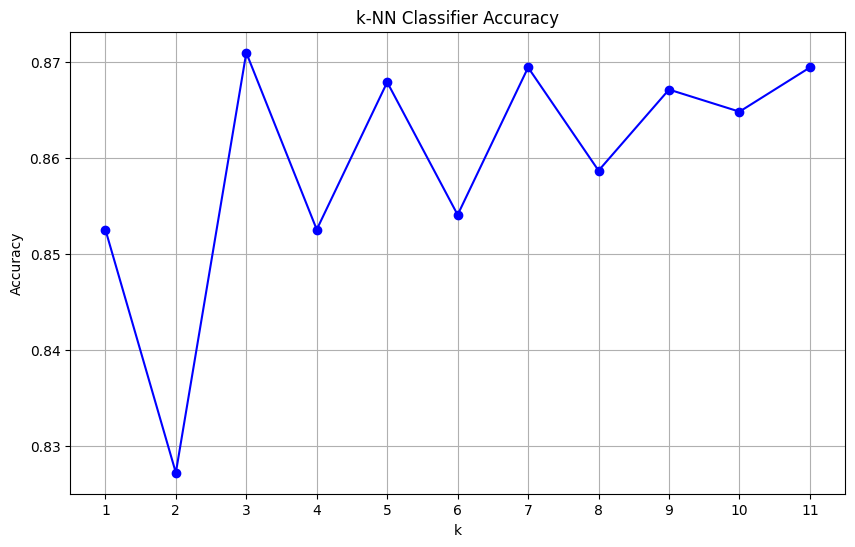

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 12)
accuracies = []

for k in k_values:
    neigh = KNeighborsClassifier(n_neighbors=k)

    neigh.fit(X_train, y_train)
 
    y_pred = neigh.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    accuracies.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('k-NN Classifier Accuracy')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Data):")
print(conf_matrix_test)

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("\nConfusion Matrix (Training Data):")
print(conf_matrix_train)

print("\nClassification Report (Test Data):")
print(classification_report(y_test, y_pred_test))

print("Classification Report (Training Data):")
print(classification_report(y_train, y_pred_train))

Confusion Matrix (Test Data):
[[345  67]
 [103 787]]

Confusion Matrix (Training Data):
[[ 784  109]
 [ 182 1963]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       412
           1       0.92      0.88      0.90       890

    accuracy                           0.87      1302
   macro avg       0.85      0.86      0.85      1302
weighted avg       0.87      0.87      0.87      1302

Classification Report (Training Data):
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       893
           1       0.95      0.92      0.93      2145

    accuracy                           0.90      3038
   macro avg       0.88      0.90      0.89      3038
weighted avg       0.91      0.90      0.91      3038

